## Part 3 - Clustering using both image and text

In part 1 and part 2, we have practived the art of clustering text and images separately.
However, can we map image and text to the same space? In the Pokemon world, Pokedex
catalogs Pokemon’s appearances and various metadata. We will build our Pokedex from image
dataset link and meta metadata link. Fortunately, ECE 219 Gym kindly provides new Pokemon
trainers with the helper code for data preprocessing and inferencing. Please find the code on
Bruinlearn modules Week 4.

We will use the pre-trained CLIP [8] to illustrate the idea of multimodal clustering. CLIP
(Contrastive Language–Image Pretraining) is an innovative model developed by OpenAI, de-
signed to understand and connect concepts from both text and images. CLIP is trained on a
vast array of internet-sourced text-image pairs. This extensive training enables the model to
understand a broad spectrum of visual concepts and their textual descriptions.

CLIP consists of two primary components: a text encoder and an image encoder. The text
encoder processes textual data, converting sentences and phrases into numerical representa-
tions. Simultaneously, the image encoder transforms visual inputs into a corresponding set
of numerical values. These encoders are trained to map both text and images into a shared
embedding space, allowing the model to compare and relate the two different types of data di-
rectly. The training employs a contrastive learning approach, where the model learns to match
corresponding text and image pairs against numerous non-matching pairs. This approach helps
the model in accurately associating images with their relevant textual descriptions and vice
versa.

In [ ]:
!pip install datasets transformers numpy pandas Pillow matplotlib
!pip install torch tqdm scipy
!pip install git+https://github.com/openai/CLIP.git
!pip install plotly umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Imports
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import clip
import torch
from tqdm import tqdm
from scipy.special import softmax
import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE

In [ ]:
# Setup Code
# load csv file and image paths to construct pokedex, use type_to_load=None to load all types, else use a list of types 1 to load
def construct_pokedex(csv_path='/content/drive/MyDrive/Pokemon.csv', image_dir='/content/drive/MyDrive/images', type_to_load=None):
    pokedex = pd.read_csv(csv_path)
    image_paths = []

    for pokemon_name in pokedex["Name"]:
        imgs = glob(f"{image_dir}/{pokemon_name}/0.jpg")
        if len(imgs) > 0:
            image_paths.append(imgs[0])
        else:
            image_paths.append(None)

    pokedex["image_path"] = image_paths
    pokedex = pokedex[pokedex["image_path"].notna()].reset_index(drop=True)

    # only keep pokemon with distinct id
    ids, id_counts = np.unique(pokedex["ID"], return_counts=True)
    ids, id_counts = np.array(ids), np.array(id_counts)
    keep_ids = ids[id_counts == 1]

    pokedex = pokedex[pokedex["ID"].isin(keep_ids)].reset_index(drop=True)
    pokedex["Type2"] = pokedex["Type2"].str.strip()
    if type_to_load is not None:
        pokedex = pokedex[pokedex["Type1"].isin(type_to_load)].reset_index(drop=True)
    return pokedex

# load clip model
def load_clip_model():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-L/14", device=device)
    return model, preprocess, device

# inference clip model on a list of image path
def clip_inference_image(model, preprocess, image_paths, device):
    image_embeddings = []
    with torch.no_grad():
        for img_path in tqdm(image_paths):
            img = Image.open(img_path)
            img_preprocessed = preprocess(img).unsqueeze(0).to(device)
            image_embedding = model.encode_image(img_preprocessed).detach().cpu().numpy()
            image_embeddings += [image_embedding]

    image_embeddings = np.concatenate(image_embeddings, axis=0)
    image_embeddings /= np.linalg.norm(image_embeddings, axis=-1, keepdims=True)
    return image_embeddings

# inference clip model on a list of texts
def clip_inference_text(model, preprocess, texts, device):
    with torch.no_grad():
        text_embeddings = model.encode_text(clip.tokenize(texts).to(device)).detach().cpu().numpy()
    text_embeddings /= np.linalg.norm(text_embeddings, axis=-1, keepdims=True)
    return text_embeddings

# compute similarity of texts to each image
def compute_similarity_text_to_image(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=-1)
    return similarity

# compute similarity of iamges to each text
def compute_similarity_image_to_text(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=0)
    return similarity

# Use TSNE to project CLIP embeddings to 2D space
def umap_projection(image_embeddings, n_neighbors=15, min_dist=0.1, metric='cosine'):
    distance_matrix = np.zeros((image_embeddings.shape[0], image_embeddings.shape[0]))
    for i in range(image_embeddings.shape[0]):
        for j in range(image_embeddings.shape[0]):
            if i == j:
                distance_matrix[i, j] = 1
            else:
                distance_matrix[i, j] = np.dot(image_embeddings[i], image_embeddings[j])
    distance_matrix = 1 - distance_matrix
    reducer = TSNE(n_components=2, metric="precomputed", init="random", random_state=42)
    visualization_data = reducer.fit_transform(distance_matrix)
    return visualization_data

### QUESTION 26:
Try to construct various text queries regarding types of Pokemon (such as ”type:
Bug”, ”electric type Pok ́emon” or ”Pok ́emon with fire abilities”) to find the relevant images from
the dataset. Once you have found the most suitable template for queries, please find the top five
most relevant Pokemon for type Bug, Fire and Grass. For each of the constructed query, please plot
the five most relevant Pokemon horizontally in one figure with following specifications:
- the title of the figure should be the query you used;
- the title of each Pokemon should be the name of the Pokemon and its first and second type.

Repeat this process for Pokemon of Dark and Dragon types. Assess the effectiveness of your queries
in these cases as well and try to explain any differences.

In [ ]:
# Code for Q26
# Load the Pokedex data
pokedex = construct_pokedex()

In [ ]:
# Define type queries
type_queries = {
    "Bug": "A Pokémon of Bug type",
    "Fire": "A Pokémon of Fire type",
    "Grass": "A Pokémon of Grass type",
    "Dark": "A Pokémon of Dark type",
    "Dragon": "A Pokémon of Dragon type"
}

In [ ]:
import numpy as np

# Load CLIP model
model, preprocess, device = load_clip_model()

# Encode text queries
text_embeddings = clip_inference_text(model, preprocess, list(type_queries.values()), device)

# Encode Pokémon images
image_embeddings = clip_inference_image(model, preprocess, pokedex["image_path"], device)

# Compute similarity between text queries and images
similarities = compute_similarity_text_to_image(image_embeddings, text_embeddings)

# Get the top 5 most relevant Pokémon for each type
top_k_indices = np.argsort(similarities, axis=0)[-5:][::-1]

100%|███████████████████████████████████████| 890M/890M [00:21<00:00, 43.6MiB/s]
100%|██████████| 754/754 [05:25<00:00,  2.31it/s]


In [ ]:
# Function to plot top Pokémon results
def plot_top_pokemon(top_indices, query, type_name):
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    fig.suptitle(f"Text Query: {query}", fontsize=16)

    for i, idx in enumerate(top_indices):
        pokemon_name = pokedex.iloc[idx]["Name"]
        pokemon_type1 = pokedex.iloc[idx]["Type1"]
        pokemon_type2 = pokedex.iloc[idx]["Type2"]
        img_path = pokedex.iloc[idx]["image_path"]

        # Load and display the Pokémon image
        image = Image.open(img_path)
        axes[i].imshow(image)
        axes[i].axis("off")
        axes[i].set_title(f"{pokemon_name}\n({pokemon_type1}, {pokemon_type2})", fontsize=12)

    plt.tight_layout(pad=2.0)
    plt.show()


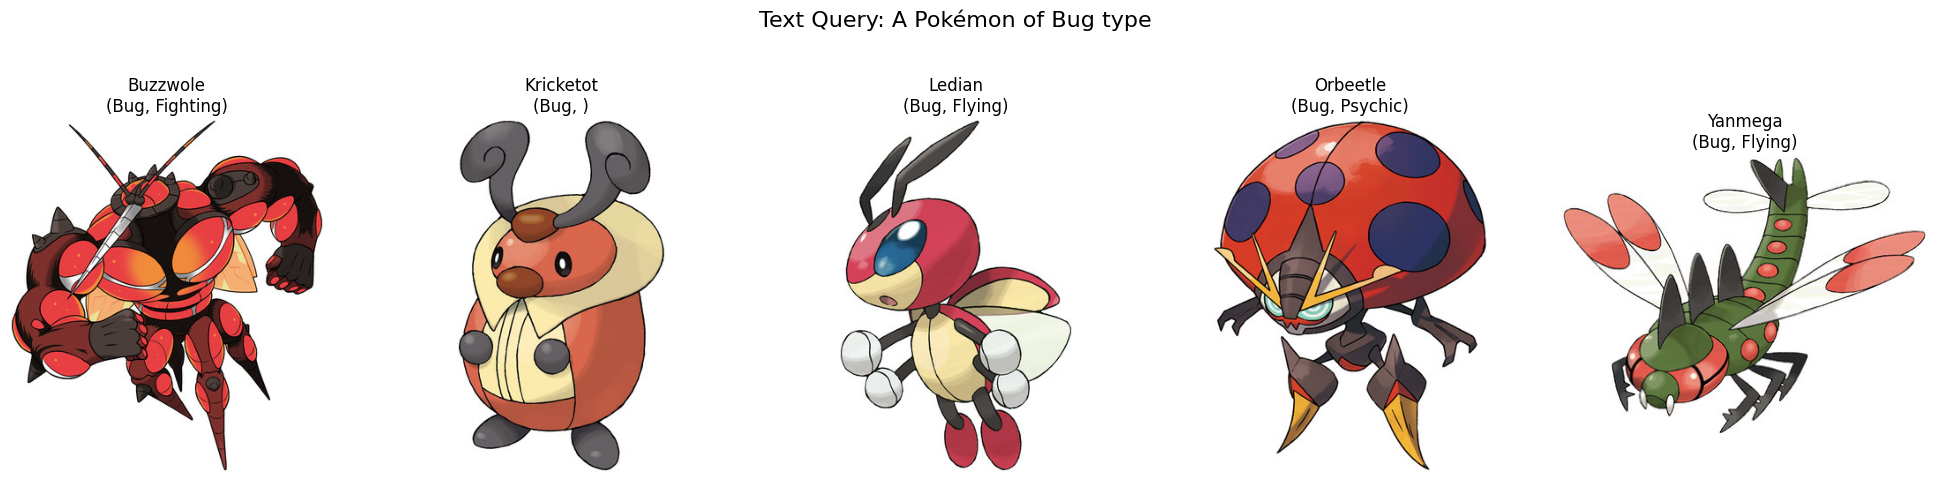

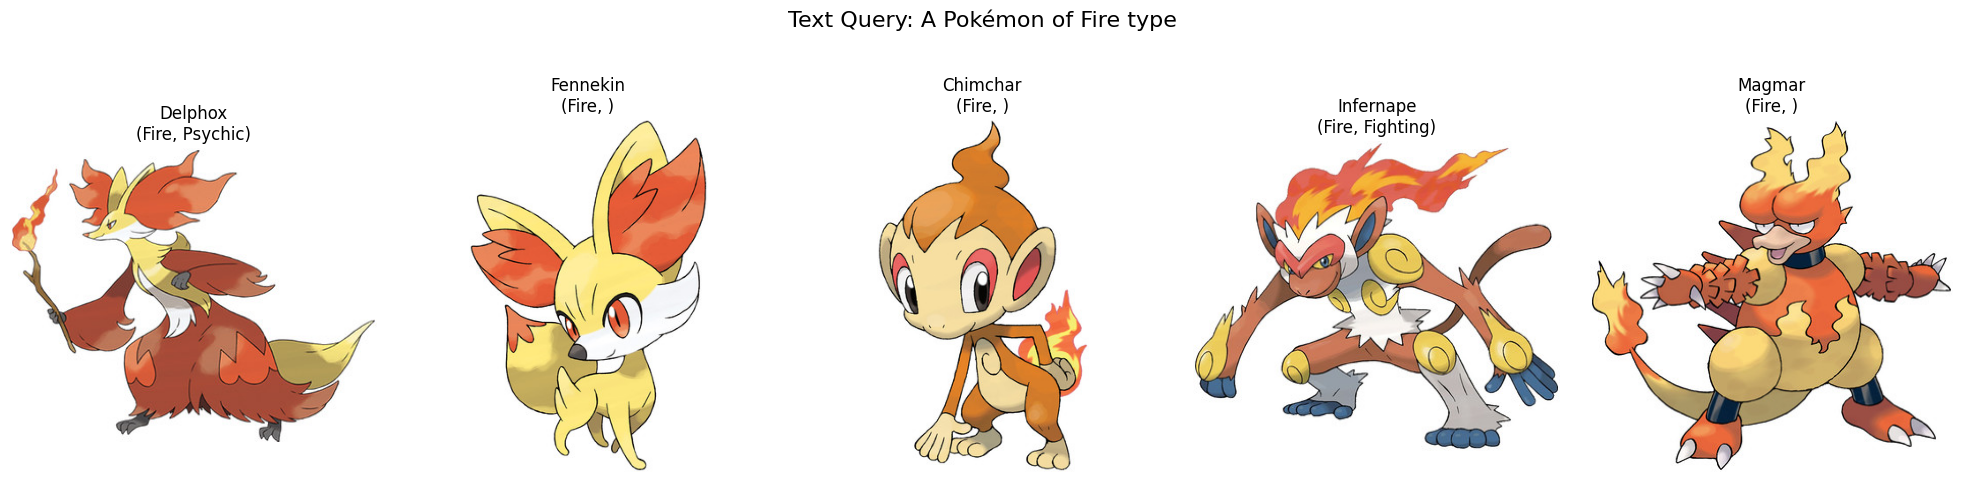

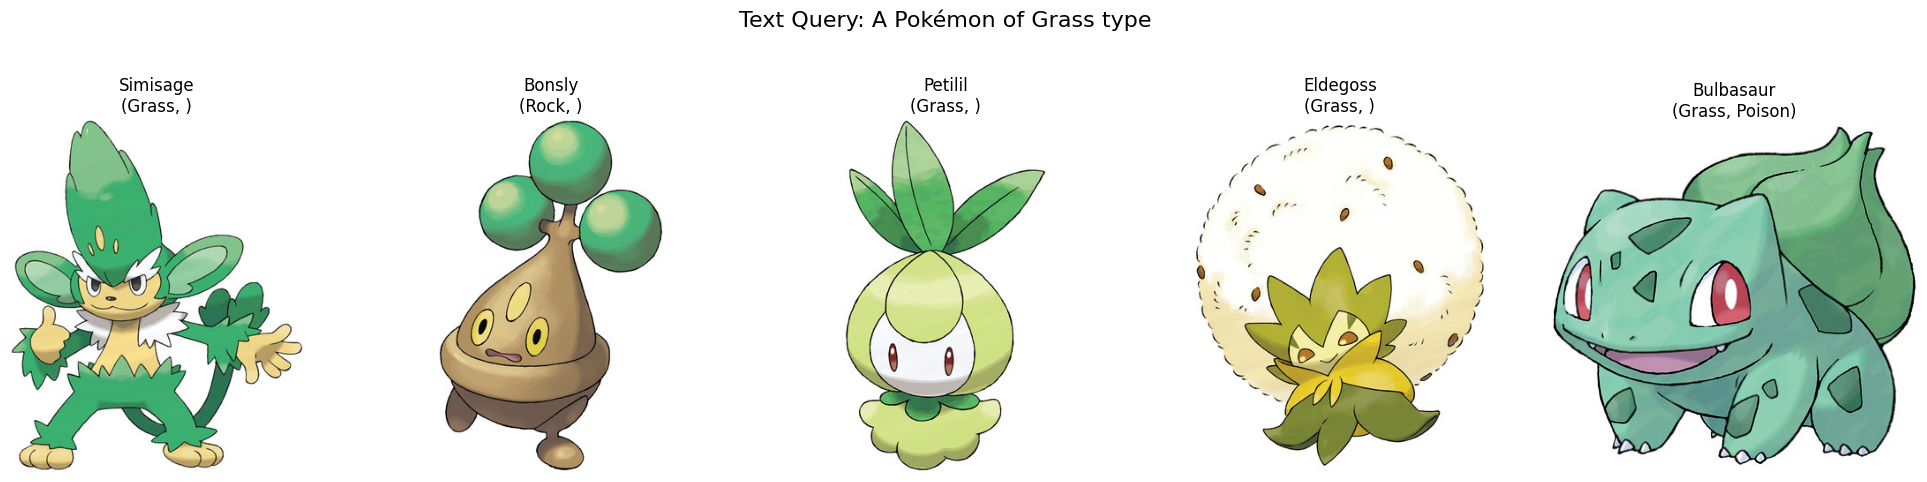

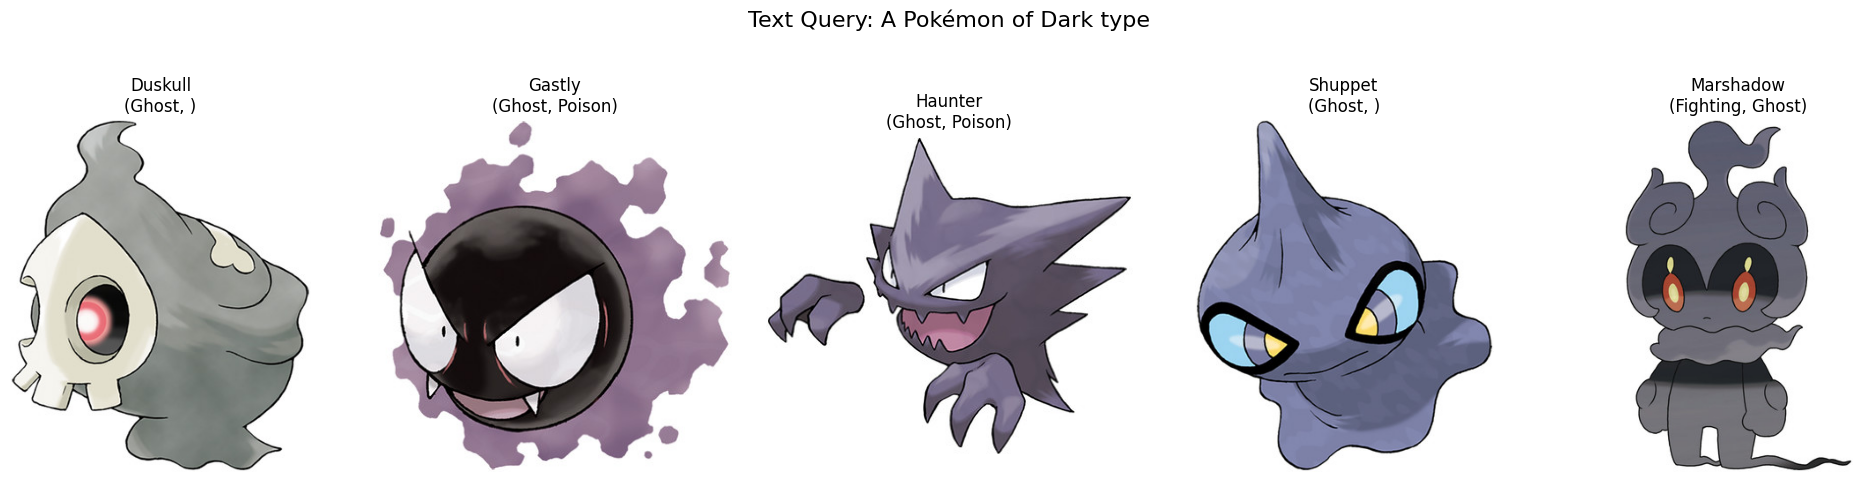

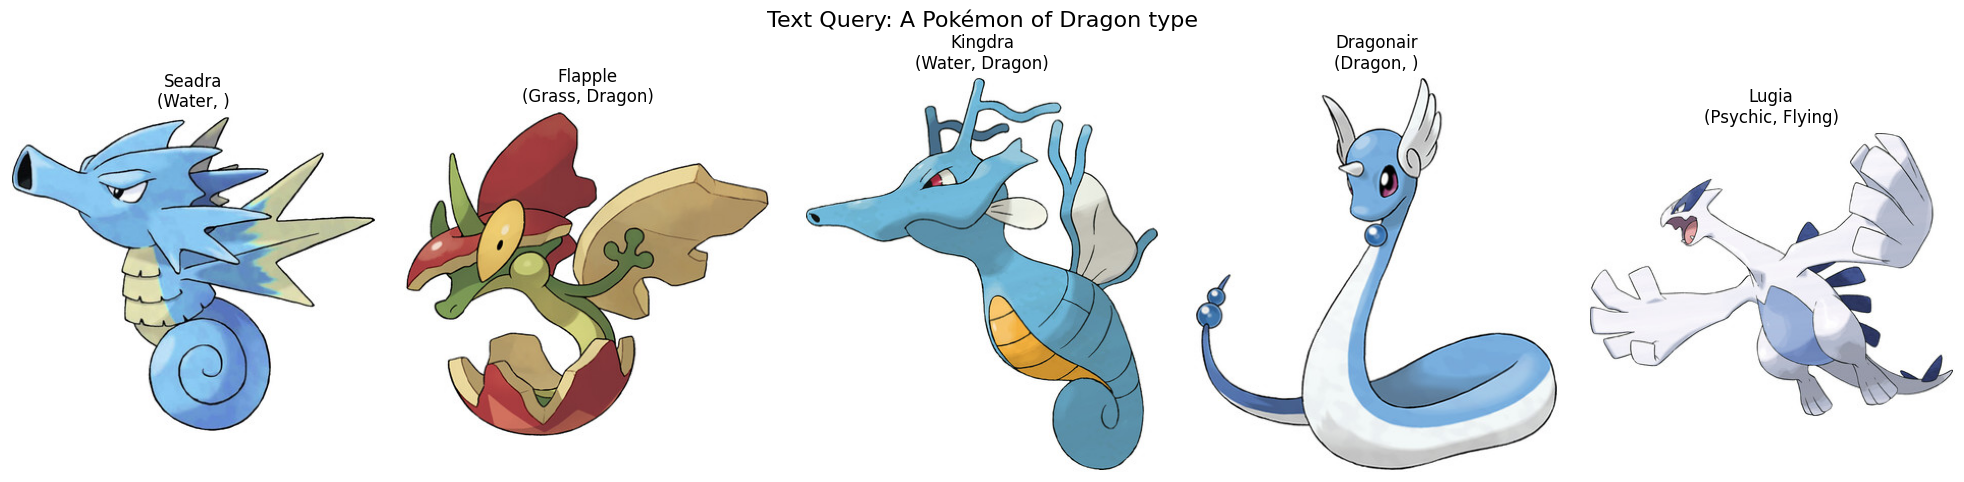

In [ ]:
# Loop through all types and plot results
for type_name, query in type_queries.items():
    top_indices = top_k_indices[:, list(type_queries.keys()).index(type_name)]
    plot_top_pokemon(top_indices, query, type_name)

### Answer
The results of the queries can be seen above. Judging by these results, the queries were actually very effective. In almost every single case the query resulted in pokemen from the rolodex that perfectly matched the query type. There are a few off cases where the pokemon is not of the correct type. For example, pokemon of bug, and fire were 100% accurate. This is most likwly because it prioritized the respective bright green and red colors which are. abit easier to isolate within images. One case where it didnt perform as well is for dark type. The queue seems to be . mit more ambiguous and the results reflect this. The pokemon are . bit darker in hugh but not always the correct type. This shows how ambiguity in queue and uniqueness can result in worst accuracy and results overall.

### QUESTION 27:
Randomly select 10 Pokemon images from the dataset and use CLIP to find the
most relevant types (use your preferred template, e.g ”type: Bug”). For each selected Pokemon,
please plot it and indicate:
- its name and first and second type;
- the five most relevant types predicted by CLIP and their predicted probabilities.

In [ ]:
# Code for Q27
# Extract unique types
unique_types = pd.unique(pd.concat([pokedex['Type1'], pokedex['Type2']])).tolist()

# Construct query dictionary
type_queries = {t: f"type: {t}" for t in unique_types if pd.notna(t)}

# Load CLIP model
model, preprocess, device = load_clip_model()

# Encode type queries using CLIP
query_embeddings = clip_inference_text(model, preprocess, list(type_queries.values()), device)

# Select 10 random Pokémon (random seed = 108)
selected_pokemon = pokedex.sample(n=10, random_state=108).reset_index(drop=True)

In [ ]:
# Function to predict top 5 Pokémon types using CLIP
def predict_types(image_paths):
    # Encode Pokémon images using CLIP
    image_embeddings = clip_inference_image(model, preprocess, image_paths, device)

    # Compute similarity scores (text-to-image)
    similarity_scores = compute_similarity_text_to_image(image_embeddings, query_embeddings)

    # Get top 5 predicted types for each image
    predicted_types = []
    for scores in similarity_scores:
        top_indices = np.argsort(scores)[::-1][:5]
        relevant_types = [(list(type_queries.keys())[i], scores[i]) for i in top_indices]
        predicted_types.append(relevant_types)

    return predicted_types

# Function to plot Pokémon with actual and predicted types
def plot_pokemon_with_predictions(pokemon_name, type1, type2, image_path, predicted_types):
    plt.figure(figsize=(6, 6))

    # Load and display
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis("off")

    # Title
    plt.title(f"{pokemon_name}\n Type 1: {type1}, Type 2: {type2}", fontsize=14)

    # Display predicted types with probabilities
    caption = "\n".join([f"{ptype}: {prob:.4f}" for ptype, prob in predicted_types])
    plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=12)

    plt.show()

100%|██████████| 1/1 [00:00<00:00, 32.84it/s]


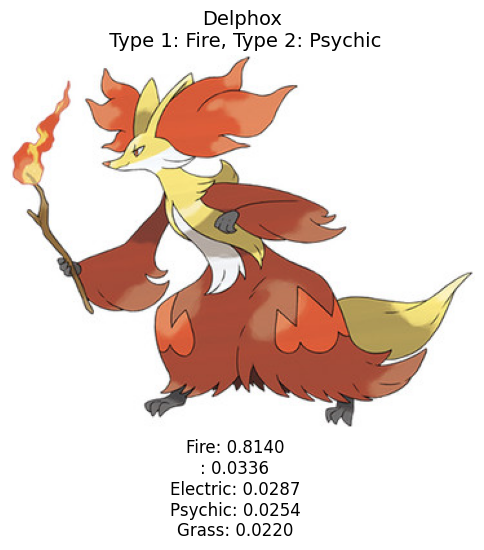

100%|██████████| 1/1 [00:00<00:00, 27.22it/s]


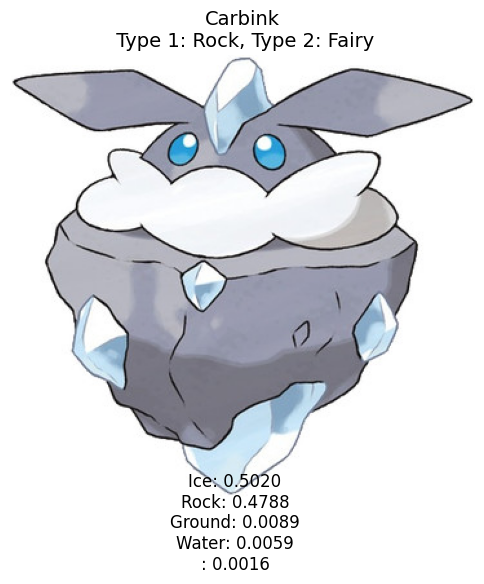

100%|██████████| 1/1 [00:00<00:00, 26.55it/s]


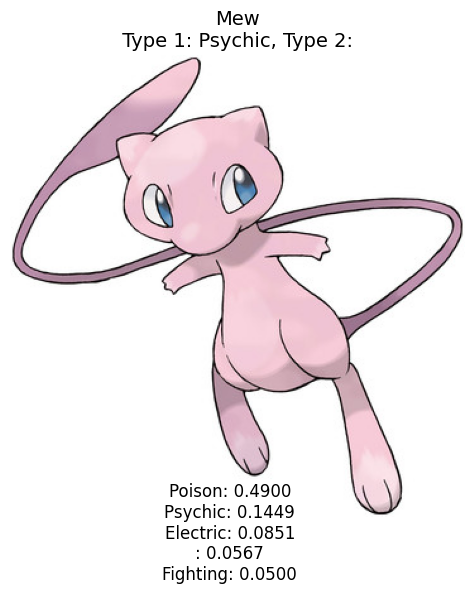

100%|██████████| 1/1 [00:00<00:00, 28.09it/s]


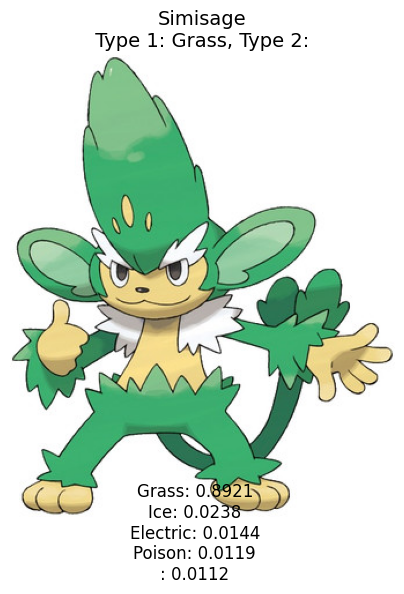

100%|██████████| 1/1 [00:00<00:00, 22.80it/s]


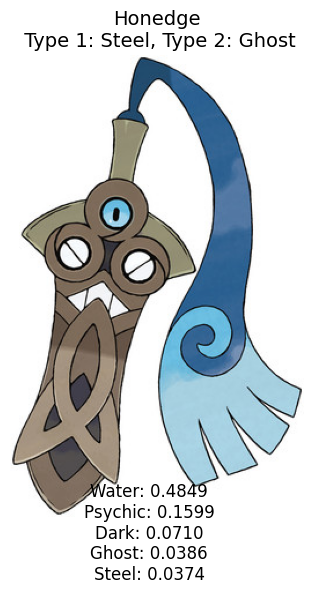

100%|██████████| 1/1 [00:00<00:00, 27.96it/s]


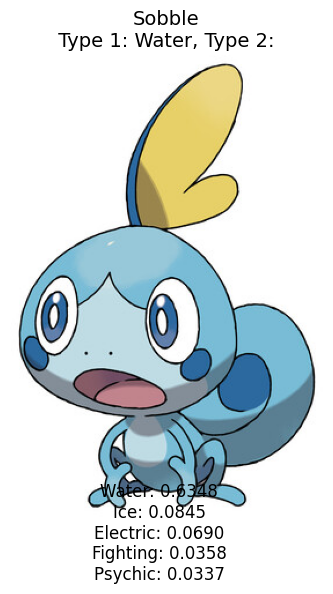

100%|██████████| 1/1 [00:00<00:00, 30.56it/s]


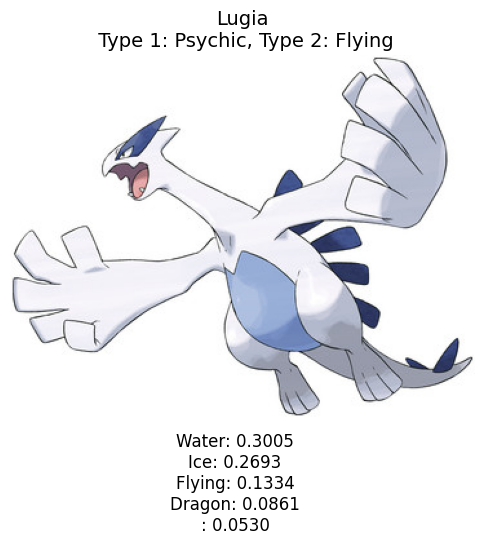

100%|██████████| 1/1 [00:00<00:00, 30.62it/s]


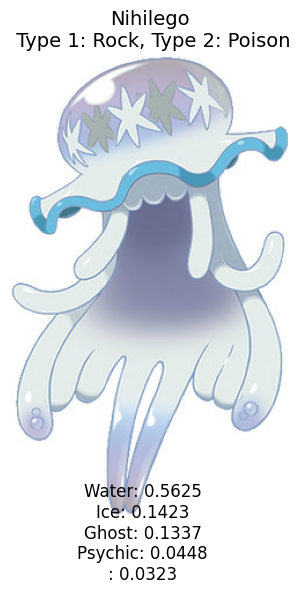

100%|██████████| 1/1 [00:00<00:00, 27.43it/s]


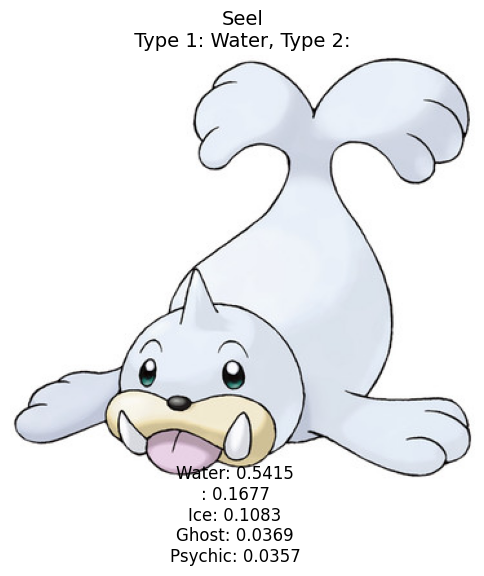

100%|██████████| 1/1 [00:00<00:00, 25.65it/s]


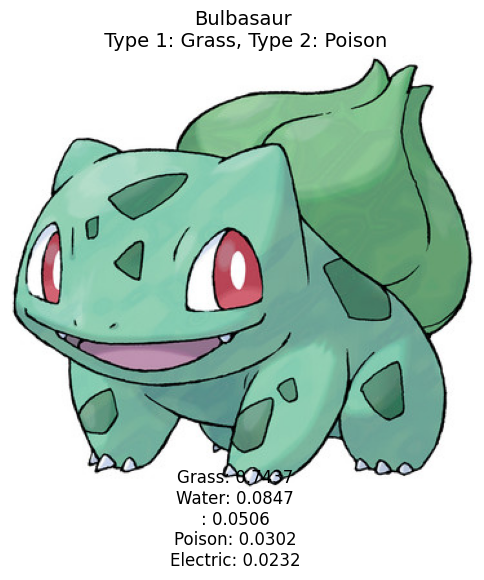

In [ ]:
# Process each Pokémon and display results
for _, row in selected_pokemon.iterrows():
    pokemon_name = row['Name']
    type1 = row['Type1']
    type2 = row['Type2'] if pd.notna(row['Type2']) else "None"
    image_path = row['image_path']

    predicted_types = predict_types([image_path])[0]  # Get predictions for the Pokémon
    plot_pokemon_with_predictions(pokemon_name, type1, type2, image_path, predicted_types)


### QUESTION 28:
In the first and second question, we investigated how CLIP creates ’clusters’ by
mapping images and texts of various Pokemon into a high-dimensional space and explored neighbor-
hood of these items in this space. For this question, please use t-SNE to visualize image clusters,
specifically for Pokemon types Bug, Fire, and Grass. You can use scatter plot from python package
plotly. For the visualization, color-code each point based on its first type type 1 using the ’color’
argument, and label each point with the Pokemon’s name and types using ’hover name’. This
will enable you to identify each Pokemon represented in your visualization. After completing the
visualization, analyze it and discuss whether the clustering of Pokemon types make sense to you.

In [ ]:
# Code for Q28
# Select Pokémon of types Bug, Fire, and Grass
selected_types = ["Bug", "Fire", "Grass"]
filtered_pokedex = pokedex[pokedex["Type1"].isin(selected_types)].reset_index(drop=True)

# Load CLIP model
model, preprocess, device = load_clip_model()

# Compute image embeddings using CLIP
image_embeddings = clip_inference_image(model, preprocess, filtered_pokedex["image_path"].tolist(), device)

# Reduce dimensions using t-SNE
tsne = TSNE(n_components=2, perplexity=15, random_state=42, metric="cosine")
tsne_results = tsne.fit_transform(image_embeddings)

plot_data = pd.DataFrame({
    "x": tsne_results[:, 0],
    "y": tsne_results[:, 1],
    "Name": filtered_pokedex["Name"],
    "Type1": filtered_pokedex["Type1"],
    "Type2": filtered_pokedex["Type2"]
})

# Create plot
fig = px.scatter(
    plot_data,
    x="x",
    y="y",
    color="Type1",
    hover_data={"Name": True, "Type1": True, "Type2": True}
)

# Show plot
fig.show()

100%|██████████| 192/192 [00:04<00:00, 42.88it/s]


After completing the visualization, analyze it and discuss whether the clustering of Pokemon types make sense to you.

### Answer:
The scatter plot visualize Pokémon embeddings for types Bug, Fire, and Grass (based on type-1 and type-2 criteria). Based on this scatter plot, there is not a clear division between the types. We can see that the different groupings are forming but they flow into eachother pretty seamlessly and there is a lot of confusion as to the type and its belonging on the plot. These boundaries between types somewhatb allign with pokemon development through types within the same species so this scatterplot in reality does make sense according to the further researched lore of the characters.


![Alt text](q28_plot.png)